In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('reuters')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [0]:
import os
import sys
import numpy as np

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU, MaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Input
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import average
from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
MAX_SEQUENCE_LENGTH = 2380
MAX_NUM_WORDS = 40000
EMBEDDING_DIM = 300

subset = ['potato', 'rand', 'wpi', 'wheat', 'yen']

n_classes = 90
labels = reuters.categories()
mlb = MultiLabelBinarizer(labels)

In [0]:
# LOAD DATASET

# Function to load dataset
def load_set(set_name):
  # Load Training Data
  data_ids =  list(filter(lambda x: x.startswith(set_name), reuters.fileids()))
  data = [reuters.raw(doc_id) for doc_id in data_ids]
  labels = [reuters.categories(doc_id) for doc_id in data_ids]
  return data, labels

# Load Training Set and Labels
train_data, train_labels = load_set('training/')

# Load Validation Set and Labels
split = round(len(train_data)*0.90)

validation_data = train_data[split+1:]
validation_labels = train_labels[split+1:]

train_data = train_data[:split]
train_labels = train_labels[:split]

# Load Testing Set and Labels
test_data, test_labels = load_set('test/')



print ('Dataset Loaded...')
print ('Training Data: {} Samples, {} Labels'.format(len(train_data), len(train_labels)))
print ('Validation Data: {} Samples, {} Labels'.format(len(validation_data), len(validation_labels)))
print ('Testing Data: {} Samples, {} Labels'.format(len(test_data), len(test_labels)))

Dataset Loaded...
Training Data: 6992 Samples, 6992 Labels
Validation Data: 776 Samples, 776 Labels
Testing Data: 3019 Samples, 3019 Labels


In [0]:
# ENCODE TEXT AND LABELS

print('Encoding Data....')

def encode(data, labels, tokenizer=None):
  # Encode Text
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data)
  sequences = tokenizer.texts_to_sequences(data)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  # Encode Labels
  labels = mlb.fit_transform(labels)
  # Create Dictsizeionary
  dictionary = tokenizer.word_index
  return data, labels, dictionary

# FETCH DATA, LABELS, DICTIONARIES
train_data, train_labels, train_dictionary = encode(train_data, train_labels)
validation_data, validation_labels, validation_dictionary = encode(validation_data, validation_labels)
test_data, test_labels, test_dictionary = encode(test_data, test_labels)

actual = test_labels

print (train_data.shape, train_labels.shape)
print (test_data.shape, test_labels.shape)
print (validation_data.shape, validation_labels.shape)

print ("Data Encoded...\n")

print ("Dictionaries Loaded...")
print ('Training Dictionary: {} Words'.format(len(train_dictionary)))
print ('Validation Dictionary: {} Words'.format(len(validation_dictionary)))
print ('Testing Dictionary: {} Words'.format(len(test_dictionary)))

Encoding Data....
(6992, 2380) (6992, 90)
(3019, 2380) (3019, 90)
(776, 2380) (776, 90)
Data Encoded...

Dictionaries Loaded...
Training Dictionary: 26351 Words
Validation Dictionary: 8918 Words
Testing Dictionary: 17774 Words


In [0]:
print('Preparing embedding matrix....\n')

print ('Loading the pretrained models...')

pretrained_model_paths = {'glove':'glove.42B.300d.txt','fasttext':'fasttext-wiki-news-300d-1M-subword.vec'}
embeddings_indexes = {}

for model, path in pretrained_model_paths.items():
  embeddings_index = {}
  print ("Loading {} model's pretrained embeddings...".format(model))
  with open('/content/drive/My Drive/sentiment_classification/' + path) as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, 'f', sep=' ')
          embeddings_index[word] = coefs
  embeddings_indexes[model] = embeddings_index
  print('Found {} word vectors in this model.'.format(len(embeddings_index)))

Preparing embedding matrix....

Loading the pretrained models...
Loading glove model's pretrained embeddings...
Found 1917494 word vectors in this model.
Loading fasttext model's pretrained embeddings...
Found 999995 word vectors in this model.


In [0]:
num_words = min(MAX_NUM_WORDS, len(train_dictionary) + 1)
embedding_matrices = {}

for model, embedding_index in embeddings_indexes.items():
  print ("Preparing {} model's embedding matrix...".format(model))
  embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
  for word, i in train_dictionary.items():
      if i >= MAX_NUM_WORDS:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  print ('Embedding Matrix Created of size', embedding_matrix.shape)
  embedding_matrices[model] = embedding_matrix

Preparing glove model's embedding matrix...
Embedding Matrix Created of size (26352, 300)
Preparing fasttext model's embedding matrix...
Embedding Matrix Created of size (26352, 300)


In [0]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# def accuracy_metric(y_true, y_pred):
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     predicted_negatives = K.sum(1 - K.round(K.clip(y_pred, 0, 1)))

#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     possible_negatives = K.sum(1 - K.round(K.clip(y_true, 0, 1)))

#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     true_negatives = K.sum(K.round(K.clip(possible_negatives * predicted_negatives, 0, 1)))   

#     accuracy = (true_positives) / (possible_positives + possible_negatives + K.epsilon())
#     return accuracy

def f1(y_true, y_pred):
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r))
    return f1

In [0]:
print ('Building Model...')

def get_model(embedding_model):
  print (embedding_model.shape)
  inputs = Input(shape=(2380,))
  embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              embeddings_initializer=Constant(embedding_model),
                              input_length=2380,
                              trainable=False)
  model = Sequential()
  model.add(embedding_layer)
  # model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
  # model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='sigmoid'))
  print(model.summary())

  return model

fast_text_model = get_model(embedding_matrices['fasttext'])
glove_model = get_model(embedding_matrices['glove'])

inputs = Input(shape=(2380,))
y1 = fast_text_model(inputs)
y2 = glove_model(inputs)
outputs = average([y1, y2])
ensemble_model = Model(inputs=inputs, outputs=outputs)

ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])

Building Model...


ValueError: ignored

In [0]:
model = Sequential()
model.add(Dense(256, input_shape=(2380,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               609536    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 90)                23130     
Total params: 698,458
Trainable params: 698,458
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
print('Training Started...\n')
history  = model.fit(train_data, train_labels,
          batch_size=128,
          epochs=4, shuffle=True,
          validation_data=(validation_data, validation_labels))

Training Started...

Train on 6992 samples, validate on 776 samples
Epoch 1/4
6992/6992 [==============================] - 1s 115us/step - loss: 1.0134 - precision: 0.0503 - recall: 0.0394 - f1: nan - val_loss: 0.2174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 2/4
6992/6992 [==============================] - 0s 39us/step - loss: 0.2227 - precision: 0.1074 - recall: 0.0015 - f1: nan - val_loss: 0.2174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 3/4
6992/6992 [==============================] - 0s 37us/step - loss: 0.2225 - precision: 0.0244 - recall: 2.4328e-04 - f1: nan - val_loss: 0.2174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 4/4
6992/6992 [==============================] - 0s 37us/step - loss: 0.2220 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: nan - val_loss: 0.2174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan


In [0]:
print ('Evaluating Model...')
score, test_precision, test_recall, test_f1 = ensemble_model.evaluate(test_data, test_labels,
                            batch_size=128)
print('\nTest score:', score)
# print('Test accuracy:', round(test_acc*100, 2))
print('Test precision:', round(test_precision*100, 2))
print('Test recall:', round(test_recall*100, 2))
print('Test F1:', round(test_f1*100, 2))

Evaluating Model...
3019/3019 [==============================] - 0s 30us/step

Test score: 0.12745497417434157
Test precision: 0.0
Test recall: 0.0
Test F1: nan


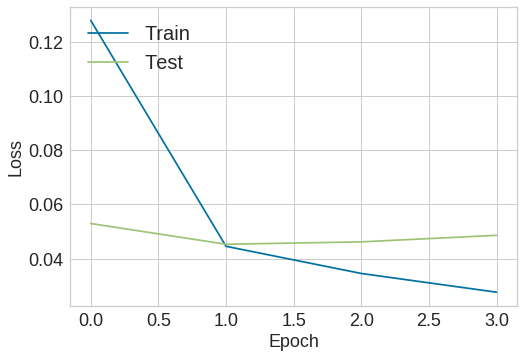

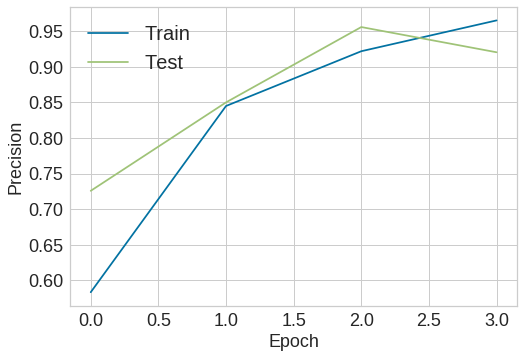

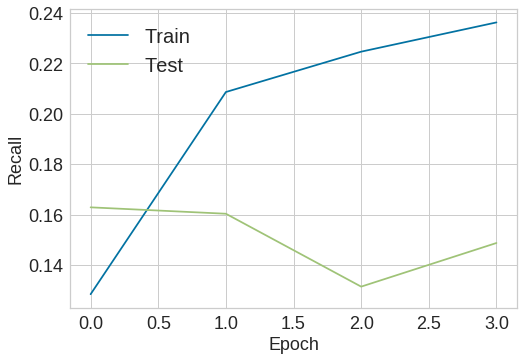

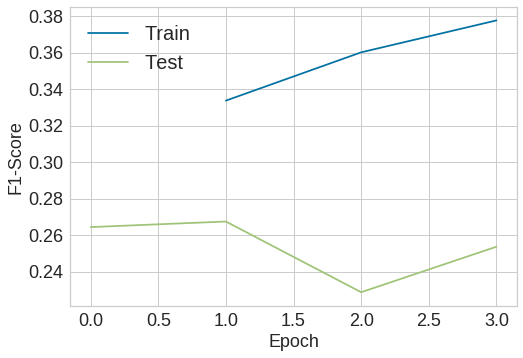

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

# Plot training & validation loss values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', prop={'size': 20})
plt.show()

In [0]:
print ("Macro Recall: ", np.mean(history.history['val_recall']))
# print ("Macro Accuracy: ", np.mean(history.history['val_accuracy_metric']))
print ("Macro Precision: ", np.mean(history.history['val_precision']))
print ("Macro F1: ", np.mean(history.history['val_f1']))

Macro Recall:  0.15083808444209934
Macro Precision:  0.8630613690799045
Macro F1:  0.25350907537126055
